# EfficientNet - Implementation from scratch in PyTorch (V1 and V2)

EfficientNet is a family of convolutional neural networks that were introduced to achieve high accuracy with significantly fewer parameters and lower computational cost. The authors demonstrated the effect of scaling on the ResNet and MobileNet and they also discovered a whole family of networks called EfficientNet through neural architecture search.

https://arxiv.org/abs/1905.11946

https://arxiv.org/abs/2104.00298

In [1]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

In [4]:
def round_channels(channels, width_mult, divisor=8, min_value=None):
    """
    Round number of channels based on width multiplier (beta).
    Ensure that all layers have a channel number that is divisible by 'divisor'.
    - This helps with efficient hardware utilization. See MobileNets.
    """
    if min_value is None:
        min_value= divisor

    new_channels= channels * width_mult
    new_channels= max(min_value, int(new_channels + divisor / 2) // divisor * divisor)
    # Prevent rounding down by more than 10%
    if new_channels < 0.9 * channels:
        new_channels += divisor

    return int(new_channels)


# Architecture Implementation

Starting by the fundamental building block of a CNN, represented by a convolutional layer. Notably, the SiLU activation is consistently utilized throughout the entire architecture as mentioned in the original paper.

Groups is specified to control how convolution is applied to input. If group=1, then a kernel is applied to all input channels and if group=in_channel (depthwise convolution), then a single convolutional kernel is applied for each input channel.

In [5]:
class ConvLayer(nn.Module):
    """
    Implements one customizable CNN layer.
    EfficientNet-style: Input -> Conv2d -> BatchNorm2d -> SiLU -> Output
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1,
                 bias=False, norm=True, activation=None) -> None:
        super(ConvLayer, self).__init__()
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias
        )
        # Batch Normalization to stabilize training
        self.norm= nn.BatchNorm2d(out_channels) if norm else None
        # Activation function -- SiLU is the default in EfficientNet
        self.activation= activation


    def forward(self, x):
        x= self.conv(x)
        if self.norm is not None:
            x= self.norm(x)
        if self.activation is not None:
            x= self.activation(x)

        return x


The Squeeze-and-Excitation module recalibrates channel-wise feature responses by learning global dependencies. It "squeezes" global spatial information into a channel descriptor using global average pooling (GAP) and then excites (reweights) each channel through a lightweight network. The primary goal is to enhance feature representation by selectively amplifying important channels.

The mechanism applies GAP to condense spatial information into a single descriptor per channel, creating a compact representation of global spatial information. These pooled features are passed to a CNN bottleneck structure and a sigmoid activation is applied on the output features, providing attention weights. The computed attention weights are applied to the original feature maps via channel-wise multiplication, dynamically emphasizing essential channels.

In [6]:
class SqueezeExcitation(nn.Module):
    """
    Implements a Squeeze-and-Excitation module.
    It squeezes global spatial information into a channel descriptor and re-scales the channels.
    """

    def __init__(self, in_channels, squeezed_dim, activation=None) -> None:
        super(SqueezeExcitation, self).__init__()
        # Activation function -- SiLU is the default in EfficientNet
        activation= nn.SiLU(inplace=True) if activation is None else activation

        # Global average pooling: C x H x W -> C x 1 x 1
        self.average_pool= nn.AdaptiveAvgPool2d(output_size=(1, 1))
        # 1x1 convolution reduces the channel dimension
        self.conv1= ConvLayer(
            in_channels, squeezed_dim, kernel_size=1, stride=1, padding=0,
            bias=True, norm=False, activation=activation
        )
        # 1x1 convolution restores the channel dimension
        # Sigmoid activation to obtain channel-wise weights between 0 and 1
        self.conv2= ConvLayer(
            squeezed_dim, in_channels, kernel_size=1, stride=1, padding=0,
            bias=True, norm=False, activation=nn.Sigmoid()
        )


    def forward(self, x):
        se= self.average_pool(x)
        se= self.conv1(se)
        se= self.conv2(se)

        return x * se


The MBConv consists of inverted residual connections and depthwise separable convolutions, which improve computational efficiency while maintaining high representational power.

The MBConv block includes:

- Expansion Convolution: Expands the input channels using a pointwise (1x1) convolution.
- Depthwise Separable Convolution: A depthwise convolution (operates per channel) followed by a pointwise (1x1) convolution, reducing computational cost.
- Squeeze-and-Excitation: This component applies GAP followed by a lightweight network to generate channel-wise attention weights, which are then applied to the feature maps.
- Stochastic Depth Regularization: Used to improve generalization and training efficiency. It randomly drops entire residual blocks during training, reducing computational load and acting as regularization to prevent overfitting.
- Residual Connection (if input/output dimensions match): Helps with gradient flow and prevents information loss.

**NOTE:** The inverted bottleneck as in MBConv does the reverse as in ResNets -- instead of reducing the number of channels, the first 1x1 conv layer increases the number of channels to 3 times the initial.

In [7]:
class StochasticDepth(nn.Module):
    """
    Implements stochastic depth regularization.
    During training, randomly drops the output of the block with probability survival_prob
    (1 - p_drop) scaling the remaining output to maintain the expected value.
    - mode: 'row' to drop per-sample, 'batch' to drop entire batch together.
    """

    def __init__(self, p_drop, mode='row') -> None:
        super(StochasticDepth, self).__init__()
        assert 0.0 <= p_drop <= 1.0, "p_drop must be in [0, 1]"
        assert mode in ('row', 'batch'), "mode must be 'row' or 'batch'"
        self.p_drop= p_drop
        self.mode= mode


    def extra_repr(self):
        return f"p={self.p_drop}, mode={self.mode}"


    def forward(self, x):
        if not self.training or self.p_drop== 0.0:
            return x

        survival_prob= 1.0 - self.p_drop

        if self.mode== 'row':
            # Mask with the same batch size and shape (broadcasted over spatial dimensions)
            mask_shape= [x.shape[0]] + [1] * (x.ndim - 1)
        else:  # 'batch'
            # Mask for the whole batch
            mask_shape= [1] * x.ndim

        mask= torch.empty(mask_shape, dtype=x.dtype, device=x.device)
        mask= mask.bernoulli_(survival_prob)
        # Scale the output to maintain expected value and apply the mask
        if survival_prob > 0.0:
            mask.div_(survival_prob)

        return x * mask


In [8]:
class MBConv(nn.Module):
    """
    Implements a Mobile Inverted Residual Block (inspired by MobileNetV3).
    Residual (skip) connection is used if stride==1 and input/output channels match.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, reduction=4,
                 drop_path=0.1, bias=False, activation=None) -> None:
        super(MBConv, self).__init__()
        assert stride in [1, 2], "Stride must be 1 or 2."
        # Activation function -- SiLU is the default in EfficientNet
        activation= nn.SiLU(inplace=True) if activation is None else activation
        # Define dimensions for intermediate layers
        hidden_dim= round_channels(in_channels, expand_ratio)
        # For squeeze and excitation module
        reduced_dim= max(1, in_channels // reduction)
        # Calculate padding to maintain spatial dimensions
        padding= kernel_size // 2

        # The inverted bottleneck block
        self.mb_conv= nn.Sequential(
            # Optional expansion phase (1x1 conv + BN + Activation)
            ConvLayer(
                in_channels, hidden_dim, kernel_size=1, stride=1, padding=0,
                bias=bias, activation=activation
            ) if (in_channels != hidden_dim) else nn.Identity(),
            # Depthwise convolution
            ConvLayer(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
                bias=bias, activation=activation
            ),
            # Squeeze-and-Excitation
            SqueezeExcitation(hidden_dim, reduced_dim, activation=activation),
            # Projection phase (1x1 conv + BN) -- reduce channels to out_channels
            ConvLayer(
                hidden_dim, out_channels, kernel_size=1, stride=1, padding=0,
                bias=bias, activation=None
            )
        )
        # When dim(x) == dim(F) and no spatial downsampling is applied -> use residual connection
        self.use_residual= (in_channels == out_channels and stride == 1)
        # For stochastic depth
        self.drop_path= StochasticDepth(drop_path) if drop_path > 0.0 else nn.Identity()


    def forward(self, x):
        # Save the original input for the residual connection
        identity= x
        # Compute the inverted bottleneck block convolutions
        out= self.mb_conv(x)
        if self.use_residual:
            out= identity + self.drop_path(out)

        return out


- Stochastic depth drops entire paths (like shortcut + block output). It is usually applied to deep residual blocks (globally).
- Dropout drops individual activations within a layer. It is usually applied to fully connected layers or inside convolutions (locally).

Thus, they regularize different levels of the model. But using both inside the same convolutional blocks might cause over-regularization, especially if survival probability is low and dropout rate is high.

**EfficientNetV2** introduced the **FusedMBConv** block where early layers have small channel counts and low expansion — here, fusing 3x3 depthwise + 1x1 pointwise into a single 3x3 regular convolution is faster on GPUs. Fused blocks in V2 don't have an SE module.

In [9]:
class FusedMBConv(nn.Module):
    """
    Implements a FusedMBConv Block (introduced by EfficientNetV2).
    Residual (skip) connection is used if stride==1 and input/output channels match.
    https://arxiv.org/abs/2104.00298
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio,
                 drop_path=0.1, bias=False, activation=None) -> None:
        super(FusedMBConv, self).__init__()
        assert stride in [1, 2], "Stride must be 1 or 2."
        # Activation function -- SiLU is the default in EfficientNet
        activation= nn.SiLU(inplace=True) if activation is None else activation
        # Define dimensions for intermediate layers
        hidden_dim= round_channels(in_channels, expand_ratio)
        # Calculate padding to maintain spatial dimensions
        padding= kernel_size // 2

        layers= nn.ModuleList()
        if hidden_dim != in_channels:
            # Fused expansion (3x3 conv + BN + Activation)
            layers.append(
                ConvLayer(
                    in_channels, hidden_dim, kernel_size, stride, padding,
                    bias=bias, activation=activation
                )
            )
            # Project (1x1 conv + BN) -- reduce channels to out_channels
            layers.append(
                ConvLayer(
                    hidden_dim, out_channels, kernel_size=1, stride=1, padding=0,
                    bias=bias, activation=None
                )
            )
        else:
            layers.append(
                ConvLayer(
                    in_channels, out_channels, kernel_size, stride, padding,
                    bias=bias, activation=activation
                )
            )
        # The Fused bottleneck block
        self.fused_mb_conv= nn.Sequential(*layers)
        # When dim(x) == dim(F) and no spatial downsampling is applied -> use residual connection
        self.use_residual= (in_channels == out_channels and stride == 1)
        # For stochastic depth
        self.drop_path= StochasticDepth(drop_path) if drop_path > 0.0 else nn.Identity()


    def forward(self, x):
        # Save the original input for the residual connection
        identity= x
        # Compute the fused bottleneck block convolutions
        out= self.fused_mb_conv(x)
        if self.use_residual:
            out= identity + self.drop_path(out)

        return out


# Define configs for different EfficientNet versions

The motivation behind introducing $\phi$ lies in the understanding that increasing the depth of the model linearly impacts the FLOPS, while changing the width or resolution has a quadratic impact. These constants were derived through neural architecture search, drawing inspiration from MnasNet.

In [10]:
base_model_v1= [
    # expand_ratio, kernel_size, stride, in_channels, out_channels, block repeats
    [1, 3, 1,  32,  16, 1],
    [6, 3, 2,  16,  24, 2],
    [6, 5, 2,  24,  40, 2],
    [6, 3, 2,  40,  80, 3],
    [6, 5, 1,  80, 112, 3],
    [6, 5, 2, 112, 192, 4],
    [6, 3, 1, 192, 320, 1],
]
base_model_v2_s= [
    [1, 3, 1,  24,  24,  2],
    [4, 3, 2,  24,  48,  4],
    [4, 3, 2,  48,  64,  4],
    [4, 3, 2,  64, 128,  6],
    [6, 3, 1, 128, 160,  9],
    [6, 3, 2, 160, 256, 15],
]
base_model_v2_m= [
    [1, 3, 1,  24,  24,  3],
    [4, 3, 2,  24,  48,  5],
    [4, 3, 2,  48,  80,  5],
    [4, 3, 2,  80, 160,  7],
    [6, 3, 1, 160, 176, 14],
    [6, 3, 2, 176, 304, 18],
    [6, 3, 1, 304, 512,  5],
]
base_model_v2_l= [
    [1, 3, 1,  32,  32,  4],
    [4, 3, 2,  32,  64,  7],
    [4, 3, 2,  64,  96,  7],
    [4, 3, 2,  96, 192, 10],
    [6, 3, 1, 192, 224, 19],
    [6, 3, 2, 224, 384, 25],
    [6, 3, 1, 384, 640,  7],
]

model_hparameters= {}                # base_model, alpha, beta, resolution, dropout, version
model_hparameters['efficientnet_b0']= (base_model_v1, 1.0, 1.0, 224, 0.2, 'v1')
model_hparameters['efficientnet_b1']= (base_model_v1, 1.1, 1.0, 240, 0.2, 'v1')
model_hparameters['efficientnet_b2']= (base_model_v1, 1.2, 1.1, 260, 0.3, 'v1')
model_hparameters['efficientnet_b3']= (base_model_v1, 1.4, 1.2, 300, 0.3, 'v1')
model_hparameters['efficientnet_b4']= (base_model_v1, 1.8, 1.4, 380, 0.4, 'v1')
model_hparameters['efficientnet_b5']= (base_model_v1, 2.2, 1.6, 456, 0.4, 'v1')
model_hparameters['efficientnet_b6']= (base_model_v1, 2.6, 1.8, 528, 0.5, 'v1')
model_hparameters['efficientnet_b7']= (base_model_v1, 3.1, 2.0, 600, 0.5, 'v1')
model_hparameters['efficientnet_v2_s']= (base_model_v2_s, 1.0, 1.0, 224, 0.2, 'v2')
model_hparameters['efficientnet_v2_m']= (base_model_v2_m, 1.0, 1.0, 380, 0.3, 'v2')
model_hparameters['efficientnet_v2_l']= (base_model_v2_l, 1.0, 1.0, 480, 0.4, 'v2')

# Building the EfficientNet

**Stem and Head**

- Stem: The network begins with a standard convolutional layer (with stride 2) to reduce spatial resolution.
- Head: After the MBConv blocks, a final 1x1 convolution, GAP, and a fully connected layer (classifier) are applied to produce the final predictions.

Scaling up any dimension of network width, depth, or resolution improves accuracy, but the accuracy gain diminishes for bigger models. In order to pursue better accuracy and efficiency, it is critical to balance all dimensions of network width, depth, and resolution during ConvNet scaling.

- Depth Scaling: Increases the number of layers (blocks) in the network.
- Width Scaling: Increases the number of channels (filters) in each layer.
- Resolution Scaling: Increases the input image size.

**Compound Scaling**: One of the major contributions of EfficientNet is its compound scaling method. Instead of scaling only one dimension (e.g., depth or width), EfficientNet scales all three dimensions (depth, width, and resolution) in a principled manner using a compound coefficient $\phi$.

In [11]:
class EfficientNet(nn.Module):
    """
    EfficientNet implementation using MBConv blocks with compound scaling.
    The compound scaling coefficients (alpha and beta) are based on the configs.
    - V1: uniform MBConv blocks
    - V2: FusedMBConv in low‑channel early layers + MBConv blocks in high‑channel later layers
    """

    def __init__(self, configs, in_channels, num_classes, last_channels=None, reduction=4,
                 bias=False, activation=None) -> None:
        super(EfficientNet, self).__init__()
        # Model configs
        base_model, alpha, beta, resolution, drop_path, version= configs
        # Base channels scaled by width_factor
        stem_channels= round_channels(base_model[0][3], beta)
        # Final channel dimension fixed for EfficientNetV2
        last_channels= 1280 if version== "v2" else last_channels
        # Activation function -- SiLU is the default in EfficientNet
        activation= nn.SiLU(inplace=True) if activation is None else activation

        # Build the backbone feature extractor
        self.backbone= nn.ModuleList([
            # Stem: Initial 3x3 conv with stride 2
            ConvLayer(
                in_channels, stem_channels, kernel_size=3, stride=2, padding=1,
                bias=bias, activation=activation
            )
        ])
        # MBConv layers
        # For each layer in the base_model, scale the number of channels and number of repeats
        total_blocks= sum(self.adjust_depth(base_model[i][5], alpha) for i in range(len(base_model)))
        block_id= 0
        stage_id= 0
        for expand_ratio, kernel_size, stride, in_chs, out_chs, repeats in base_model:
            # Scale channels using width_factor
            in_channels = round_channels(in_chs,  beta)
            out_channels= round_channels(out_chs, beta)
            layer_repeats= self.adjust_depth(repeats, alpha)

            for layer in range(layer_repeats):
                # The first layer in a block uses the specified stride; for others, use stride 1
                stride= stride if layer== 0 else 1
                # Stochastic depth probability based on the depth of the layer
                drop_rate= drop_path * float(block_id) / total_blocks

                if version== "v2" and stage_id< 3:
                    block_type= FusedMBConv(
                        in_channels, out_channels, kernel_size, stride, expand_ratio,
                        drop_rate, bias, activation
                    )
                else:
                    block_type= MBConv(
                        in_channels, out_channels, kernel_size, stride, expand_ratio, reduction,
                        drop_rate, bias, activation
                    )
                self.backbone.append(block_type)
                # Update in_channels for subsequent layers
                in_channels= out_channels
                block_id += 1
            stage_id += 1

        # Final channel dimension, scaled up to a multiple of the reduction factor
        last_channels= last_channels if last_channels is not None else reduction * in_channels

        self.backbone.append(
            # Final 1x1 conv to adjust channel dimension before classification
            ConvLayer(
                in_channels, last_channels, kernel_size=1, stride=1, padding=0,
                bias=bias, activation=activation
            )
        )

        # Pooling and classification head to produce the class logits
        self.pool= nn.AdaptiveAvgPool2d(output_size=1)
        self.head= nn.Sequential(
            nn.Dropout(p=drop_path),
            nn.Linear(last_channels, num_classes),
        )

        # initialize parameters with Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def adjust_depth(self, num_layers, depth_mult):
        """
        Adjust the number of layers based on depth multiplier (alpha).
        """
        return int(math.ceil(num_layers * depth_mult))


    def forward(self, x):
        for layer in self.backbone:
            x= layer(x)
        x= self.pool(x)
        x= torch.flatten(x, 1)
        x= self.head(x)

        return x


In [ ]:
import torchvision.models as models
from torchvision.models import EfficientNet_B0_Weights

tvis_model= models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 132MB/s] 


Number of parameters: 5288548


In [ ]:
img= torch.randn(1, 3, 224, 224).to(device)  # a single image batch
model= EfficientNet(model_hparameters['efficientnet_b0'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

model

Number of parameters: 5288548
torch.Size([1, 1000])


EfficientNet(
  (backbone): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (1): MBConv(
      (mb_conv): Sequential(
        (0): Identity()
        (1): ConvLayer(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
          (conv1): ConvLayer(
            (conv): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
          )
          (conv2): ConvLayer(
            (conv): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
       

In [ ]:
from torchvision.models import EfficientNet_B1_Weights

tvis_model= models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 153MB/s]

Number of parameters: 7794184


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_b1'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 7794184
torch.Size([1, 1000])


In [ ]:
from torchvision.models import EfficientNet_B2_Weights

tvis_model= models.efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 167MB/s]

Number of parameters: 9109994


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_b2'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 9109994
torch.Size([1, 1000])


In [ ]:
from torchvision.models import EfficientNet_B3_Weights

tvis_model= models.efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 181MB/s]


Number of parameters: 12233232


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_b3'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 12227212
torch.Size([1, 1000])


In [ ]:
from torchvision.models import EfficientNet_B4_Weights

tvis_model= models.efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 197MB/s]


Number of parameters: 19341616


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_b4'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 19341616
torch.Size([1, 1000])


In [ ]:
from torchvision.models import EfficientNet_B5_Weights

tvis_model= models.efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 189MB/s]


Number of parameters: 30389784


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_b5'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 30389784
torch.Size([1, 1000])


In [ ]:
from torchvision.models import EfficientNet_B6_Weights

tvis_model= models.efficientnet_b6(weights=EfficientNet_B6_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth
100%|██████████| 165M/165M [00:00<00:00, 218MB/s]


Number of parameters: 43040704


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_b6'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 43040704
torch.Size([1, 1000])


In [ ]:
from torchvision.models import EfficientNet_B7_Weights

tvis_model= models.efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 223MB/s]


Number of parameters: 66347960


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_b7'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 66347960
torch.Size([1, 1000])


In [ ]:
from torchvision.models import EfficientNet_V2_S_Weights

tvis_model= models.efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 170MB/s]


Number of parameters: 21458488


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_v2_s'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 21458488
torch.Size([1, 1000])


In [ ]:
from torchvision.models import EfficientNet_V2_M_Weights

tvis_model= models.efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 205MB/s]


Number of parameters: 54139356


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_v2_m'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 54139356
torch.Size([1, 1000])


In [ ]:
from torchvision.models import EfficientNet_V2_L_Weights

tvis_model= models.efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 179MB/s]


Number of parameters: 118515272


In [ ]:
model= EfficientNet(model_hparameters['efficientnet_v2_l'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 118515272
torch.Size([1, 1000])


# Training a EfficientNet models from scratch

In [12]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [13]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std= [0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 79.9MB/s]


In [14]:
len(train_loader), len(val_loader)

(352, 40)

# Trainer Function

TODO:

- Data augmentation for training.
- Play with different learning rate values.
- Play with other EfficientNet versions.

In [15]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=1, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            logits= model(images)
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    logits= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

            # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
            scheduler.step(val_loss)

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [16]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            logits= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


In [17]:
def plot_losses(train_loss, valid_loss):
    # plot training and validation losses
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

# Training setup using TF32 and Fused AdamW

In [18]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

print(f"Using fused AdamW: {use_fused}")

Using fused AdamW: True


In [19]:
# --- EfficientNet-B0 ---
in_channels= 3
num_classes= 10

modelv1= EfficientNet(model_hparameters['efficientnet_b0'], in_channels, num_classes).to(device)
count_parameters(modelv1)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    modelv1.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)

criterion= nn.CrossEntropyLoss()
# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

Number of parameters: 4020358


In [20]:
tr_loss, vl_loss= trainer(modelv1, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.5115 | Val Loss: 1.1383 | dt/epoch: 87124.00ms
Epoch: 1 | Train Loss: 0.9470 | Val Loss: 0.7501 | dt/epoch: 85408.51ms
Epoch: 2 | Train Loss: 0.6999 | Val Loss: 0.6153 | dt/epoch: 85025.23ms
Epoch: 3 | Train Loss: 0.5554 | Val Loss: 0.5396 | dt/epoch: 85197.60ms
Epoch: 4 | Train Loss: 0.4690 | Val Loss: 0.4467 | dt/epoch: 85232.59ms
Epoch: 5 | Train Loss: 0.4064 | Val Loss: 0.4403 | dt/epoch: 85375.96ms
Epoch: 6 | Train Loss: 0.3550 | Val Loss: 0.4226 | dt/epoch: 85270.46ms
Epoch: 7 | Train Loss: 0.3175 | Val Loss: 0.3834 | dt/epoch: 85300.26ms
Epoch: 8 | Train Loss: 0.2769 | Val Loss: 0.4153 | dt/epoch: 85129.91ms
Epoch: 9 | Train Loss: 0.2525 | Val Loss: 0.3646 | dt/epoch: 85500.00ms
Epoch: 10 | Train Loss: 0.2254 | Val Loss: 0.3806 | dt/epoch: 85124.27ms
Epoch: 11 | Train Loss: 0.2030 | Val Loss: 0.3943 | dt/epoch: 85167.19ms
Epoch: 12 | Train Loss: 0.1814 | Val Loss: 0.3625 | dt/epoch: 85162.19ms
Epoch: 13 | Train Loss: 0.1640 | Val Loss: 0.3756 | dt/epoch:

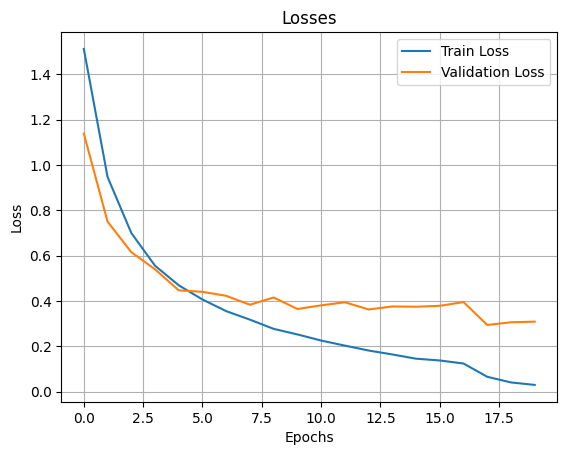

In [21]:
# plot
plot_losses(tr_loss, vl_loss)

In [22]:
effnetv1_acc= evaluate_model(modelv1, test_loader, device, verbose=True)

Accuracy: 90.77%


In [23]:
# --- EfficientNetV2-S ---
# --- V2 Training uses progressive image resizing and new optimizer choices (skipped here)
in_channels= 3
num_classes= 10

modelv2= EfficientNet(model_hparameters['efficientnet_v2_s'], in_channels, num_classes).to(device)
count_parameters(modelv2)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    modelv2.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)

criterion= nn.CrossEntropyLoss()
# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

Number of parameters: 20190298


In [24]:
tr_loss, vl_loss= trainer(modelv2, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.6140 | Val Loss: 1.2998 | dt/epoch: 104282.83ms
Epoch: 1 | Train Loss: 1.0436 | Val Loss: 0.8279 | dt/epoch: 103902.94ms
Epoch: 2 | Train Loss: 0.7770 | Val Loss: 0.6547 | dt/epoch: 104434.62ms
Epoch: 3 | Train Loss: 0.6230 | Val Loss: 0.5934 | dt/epoch: 105041.90ms
Epoch: 4 | Train Loss: 0.5280 | Val Loss: 0.5101 | dt/epoch: 105225.77ms
Epoch: 5 | Train Loss: 0.4660 | Val Loss: 0.4384 | dt/epoch: 104855.36ms
Epoch: 6 | Train Loss: 0.4075 | Val Loss: 0.4243 | dt/epoch: 104833.27ms
Epoch: 7 | Train Loss: 0.3652 | Val Loss: 0.3864 | dt/epoch: 105886.09ms
Epoch: 8 | Train Loss: 0.3260 | Val Loss: 0.4008 | dt/epoch: 105437.89ms
Epoch: 9 | Train Loss: 0.2944 | Val Loss: 0.3963 | dt/epoch: 105231.98ms
Epoch: 10 | Train Loss: 0.2687 | Val Loss: 0.3693 | dt/epoch: 104966.07ms
Epoch: 11 | Train Loss: 0.2460 | Val Loss: 0.4248 | dt/epoch: 104767.35ms
Epoch: 12 | Train Loss: 0.2241 | Val Loss: 0.3734 | dt/epoch: 105392.42ms
Epoch: 13 | Train Loss: 0.2014 | Val Loss: 0.348

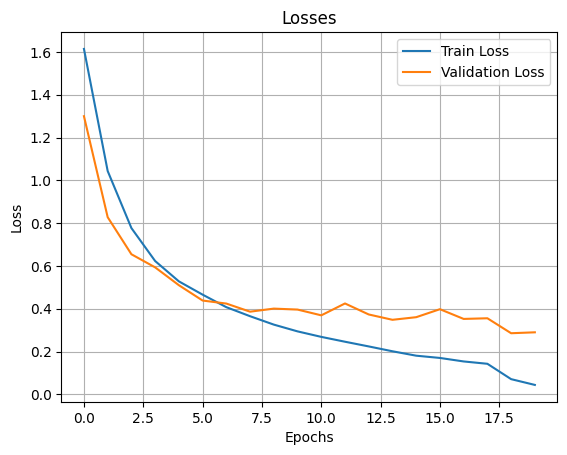

In [25]:
# plot
plot_losses(tr_loss, vl_loss)

In [26]:
effnetv2_acc= evaluate_model(modelv2, test_loader, device, verbose=True)

Accuracy: 91.09%


In [ ]:
# https://medium.com/@aniketthomas27/efficientnet-implementation-from-scratch-in-pytorch-a-step-by-step-guide-a7bb96f2bdaa
# https://amaarora.github.io/posts/2020-08-13-efficientnet.html
# https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_efficientnet.py
# https://medium.com/technological-singularity/efficientnet-revolutionizing-deep-learning-through-model-efficiency-0ed5485f9a6f